<a href="https://colab.research.google.com/github/serjisa/transcriptomics.msu/blob/main/%D0%A1%D0%B5%D0%BC%D0%B8%D0%BD%D0%B0%D1%80%D1%8B/08_%D0%9A%D0%BE%D0%BD%D1%82%D1%80%D0%BE%D0%BB%D1%8C_%D0%B7%D0%B0_%D0%B4%D0%B8%D1%81%D0%BF%D0%B5%D1%80%D1%81%D0%B8%D0%B5%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Семинар 8. Контроль за дисперсией в данных scRNA-Seq

Контроль за дисперсией — это одна из самых важных стадий анализа scRNA-Seq. От того, как он произведён, зависит многое в интерпретации данных и дальнейшем анализе, поэтому необходимо чётко понимать каждый из шагов.



In [ ]:
!pip3 install scanpy[leiden] anndata2ri scikit-misc scvi-tools scvelo
!apt-get install libgmp3-dev libcairo2-dev libharfbuzz-dev libfribidi-dev libudunits2-dev
!gdown --id 1W0TuuQospxcasOX5cQdhT_Xd-k7-QAck
!tar xf library.tar.gz

# Необходимо, чтобы конкретно прогрузился matplotlib
import os
os.kill(os.getpid(), 9)

In [ ]:
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython
%R .libPaths("usr/local/lib/R/site-library/")

'/content/...,'/usr/loca...,'/usr/lib/...,'/usr/lib/...


In [ ]:
# Установка пакета glmGamPoi, необходимого для SCTransform
import rpy2.robjects as ro
ro.r('BiocManager::install("glmGamPoi")')

In [ ]:
import scanpy as sc
import seaborn as sns
import scvelo as scv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style("ticks")
sc.set_figure_params(dpi=150)

## Распределение каунтов scRNA-Seq

Сделаем диагностический график зависимости среднего и дисперсии для каунтов, полученных в ходе анализа различных scRNA-Seq экспериментов.

In [ ]:
!gdown 1jW548g6ERFS0t7NywgyjRs6VaE5QwXbg
!gdown 1n97r-ye38uOxAr5b424L3W3P4rwahJ3C

Downloading...
From: https://drive.google.com/uc?id=1jW548g6ERFS0t7NywgyjRs6VaE5QwXbg
To: /content/PBMC_Satija.h5ad
100% 243M/243M [00:02<00:00, 88.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1n97r-ye38uOxAr5b424L3W3P4rwahJ3C
To: /content/Smart-seq2.h5ad
100% 20.8M/20.8M [00:00<00:00, 72.3MB/s]


In [ ]:
adata_10x = sc.read_h5ad("PBMC_Satija.h5ad")
adata_10x = adata_10x[adata_10x.obs.donor == "P1"]

adata_smart = sc.read_h5ad("Smart-seq2.h5ad")

In [ ]:
def f_NB(x, a):
  return x + a * x**2

def mean_var_plot(adata, fit_NB=False, fit_poly=False, log=True,
                  xlim=None, ylim=None):
  from scipy.optimize import curve_fit

  variances = np.var(adata.X.A, axis=0)
  means = adata.X.mean(axis=0).A[0][variances > 0]
  variances = variances[variances > 0]
  lim_min = min(np.min(means), np.min(variances))
  lim_max = max(np.max(means), np.max(variances))
  fig, ax = plt.subplots(figsize=(4, 4))
  ax.plot([lim_min - 0.5, lim_max + 0.5], [lim_min - 0.5, lim_max + 0.5],
          linewidth=1, color="grey", label="$Var(E) = E$")
  sns.scatterplot(x=means, y=variances, ax=ax, linewidth=0, s=3)
  if fit_NB:
    popt_NB, _ = curve_fit(f_NB, means, variances)
    fit_line_NB = np.array(range(int(lim_max))) * 0.01
    ax.plot(fit_line_NB, f_NB(fit_line_NB, *popt_NB), color="red", 
            label="$Var(E) = E + ${:.2f}$E^2$".format(popt_NB[0]))
  ax.set_ylabel("Variance")
  ax.set_xlabel("Mean")
  if log:
    ax.set_xscale("log")
    ax.set_yscale("log")
  if not(xlim is None):
    ax.set_xlim(left=xlim[0], right=xlim[1])
  else:
    ax.set_xlim(left=0, right=lim_max)
  if not(ylim is None):
    ax.set_ylim(bottom=ylim[0], top=ylim[1])
  else:
    ax.set_ylim(bottom=0, top=lim_max)
  ax.legend()

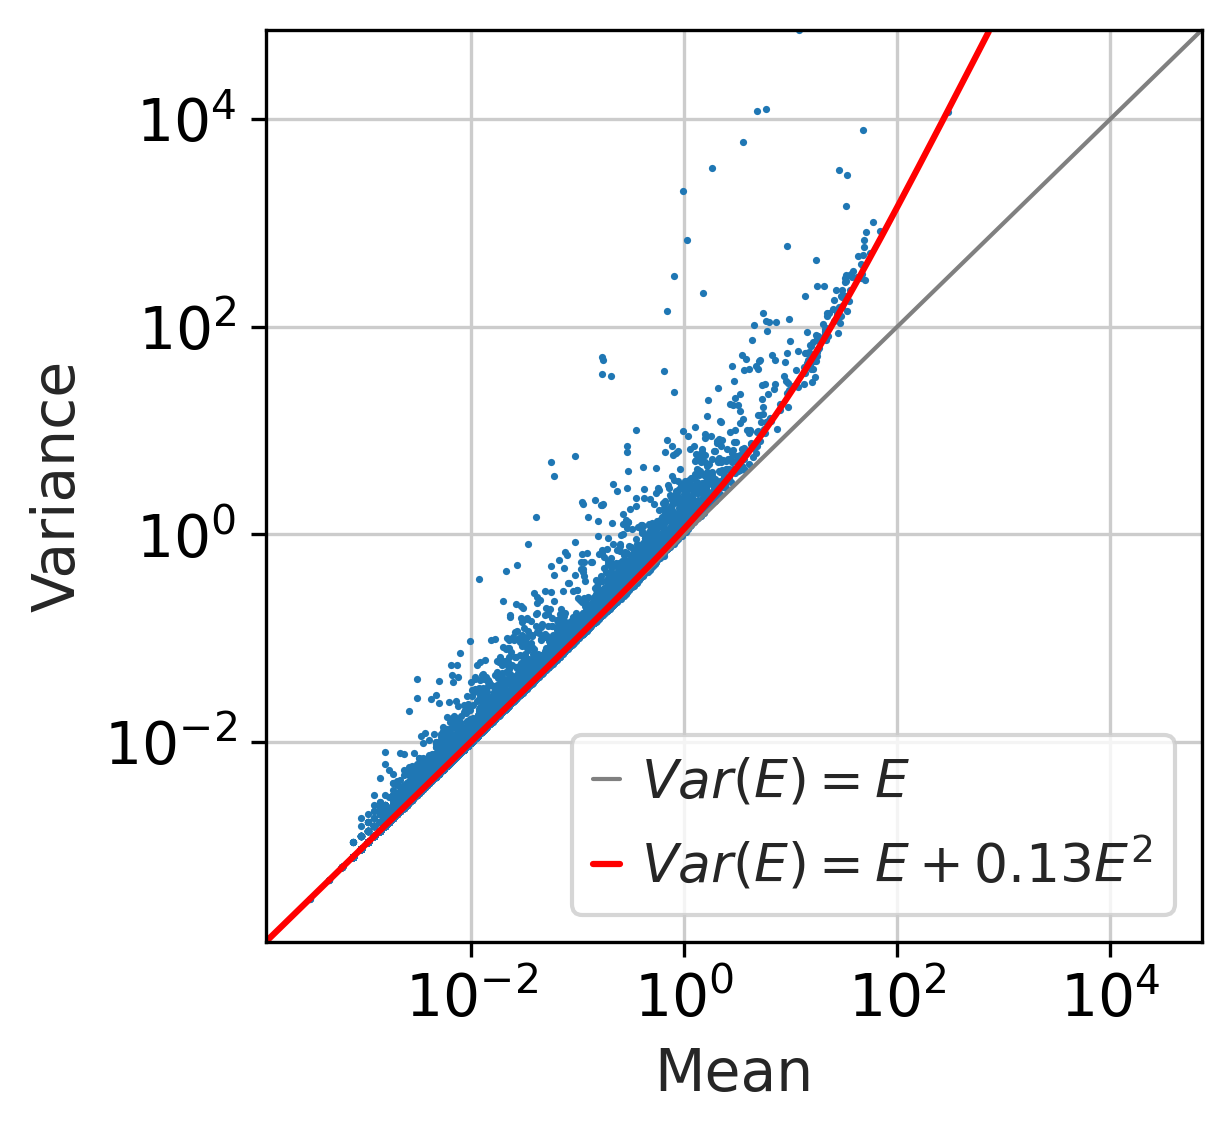

In [ ]:
mean_var_plot(adata_10x, fit_NB=True)

В нашем случае аналитический параметр $ \theta $ будет примерно равен 100 / 13 = 7.7.

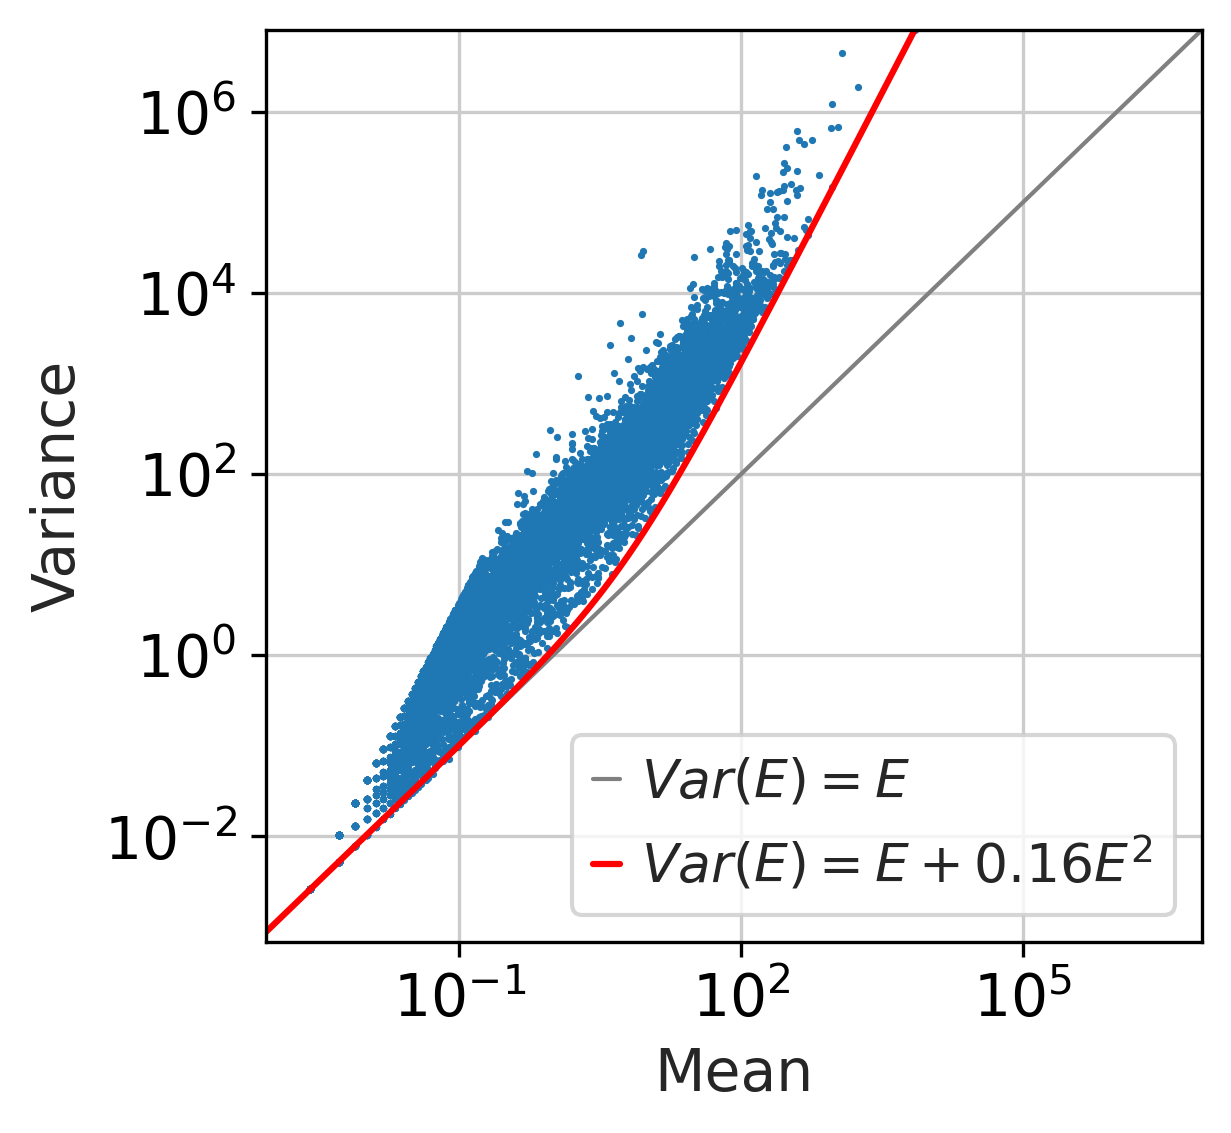

In [ ]:
mean_var_plot(adata_smart, fit_NB=True)

Зачем мы вообще пытаемся контролировать дисперсию? Наглядный пример, давайте для простоты возьмём 50 случайных клеток и 20 случайных генов (только чтобы экспрессия была ненулевая). Дальше будем работать только с датасетом 10x.

In [ ]:
adata = adata_10x.copy()
adata_raw = adata.copy()

from random import sample
adata_subsampled = adata[sample(list(adata.obs_names), 50)]
adata_subsampled = adata_subsampled[:, adata_subsampled.X.mean(axis=0).A[0] > 0]
adata_subsampled = adata_subsampled[:, sample(list(adata_subsampled.var_names), 20)]

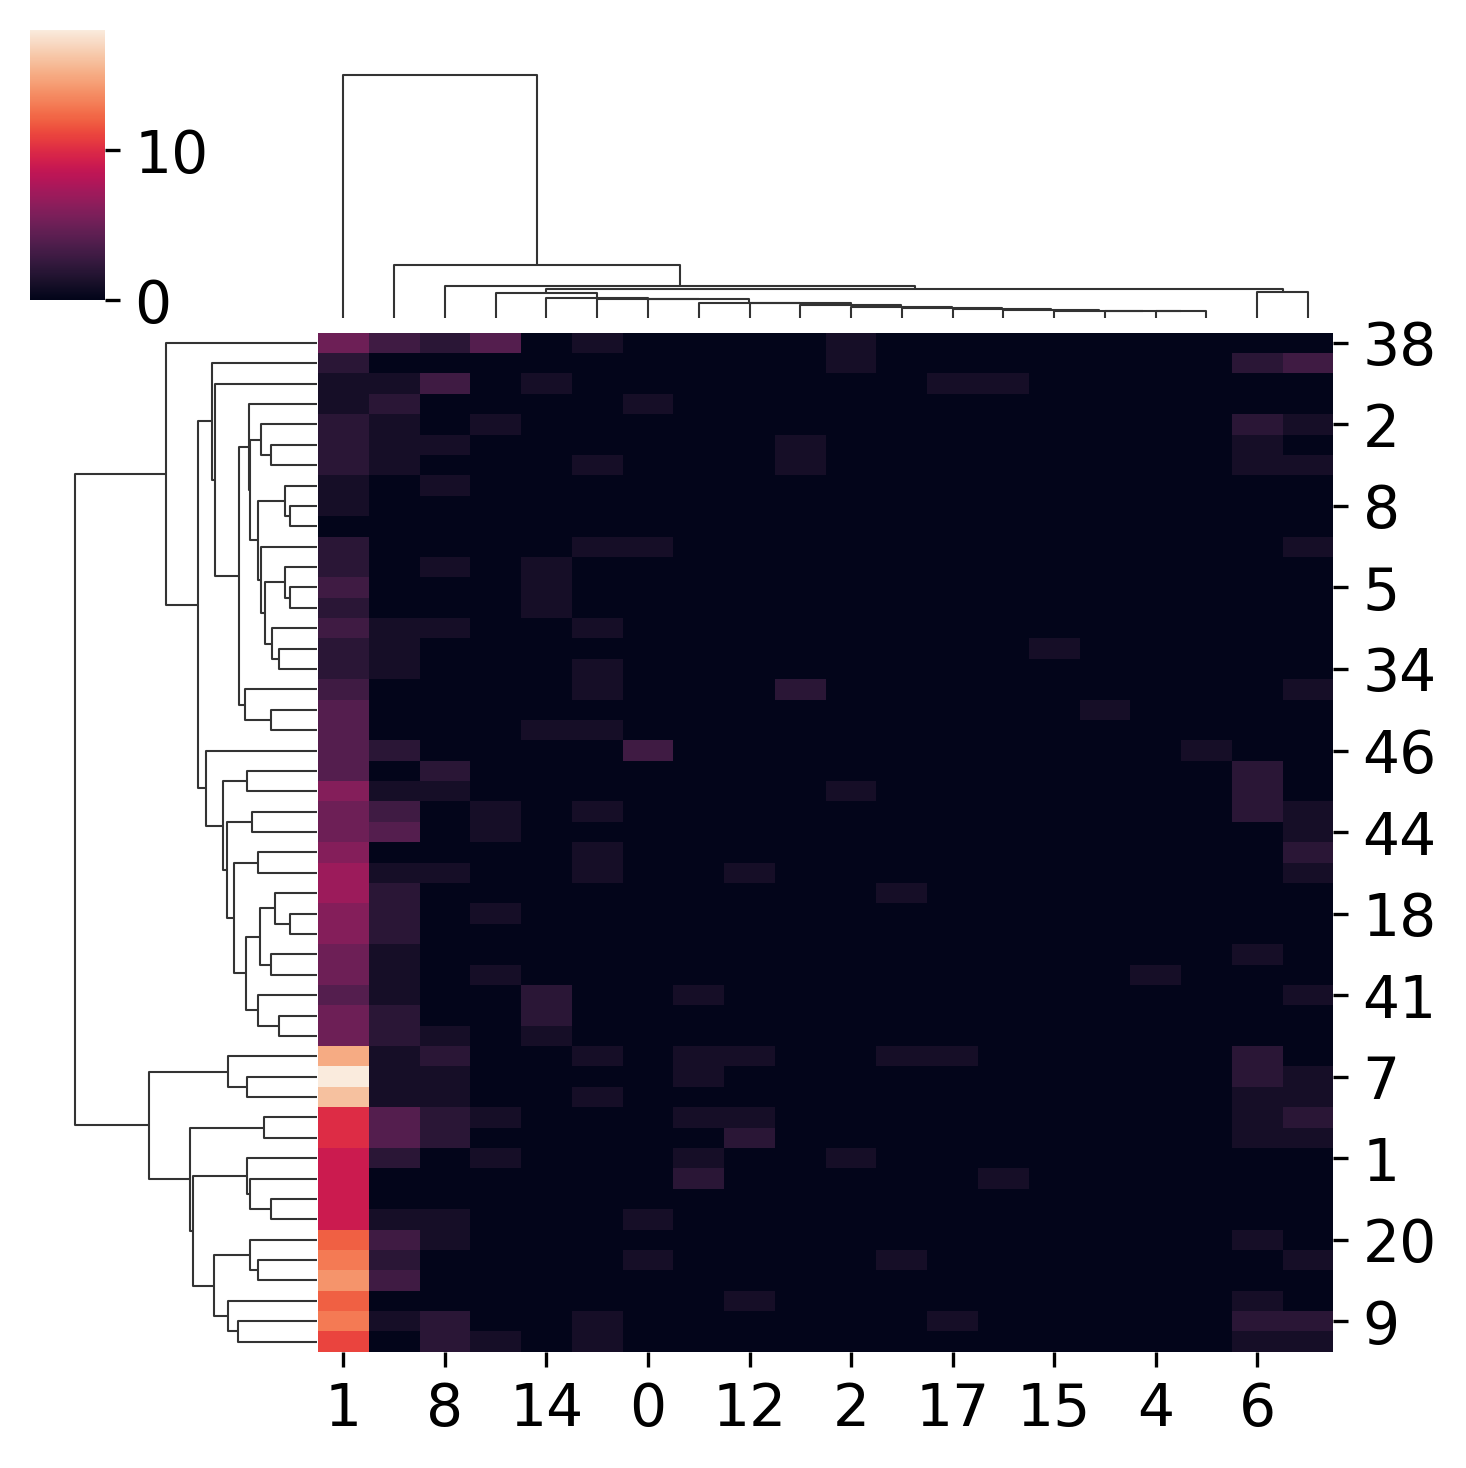

In [ ]:
sns.clustermap(adata_subsampled.X.A, figsize=(5, 5))

Что мы видим? Что при стандартных методах работы с данными, у которых у переменных различная дисперсия, мы объясняем разницу только самых высоко дисперсных признаков. Мы знаем, что у нас высокая дисперсия может быть просто по технической природе, поэтому необходимо каким-то образом за этим следить.

## Способы контроля за дисперсией: начало

Попробуем сначала найти CP10k (аналог CPM, только на 10000) и построим те же графики:

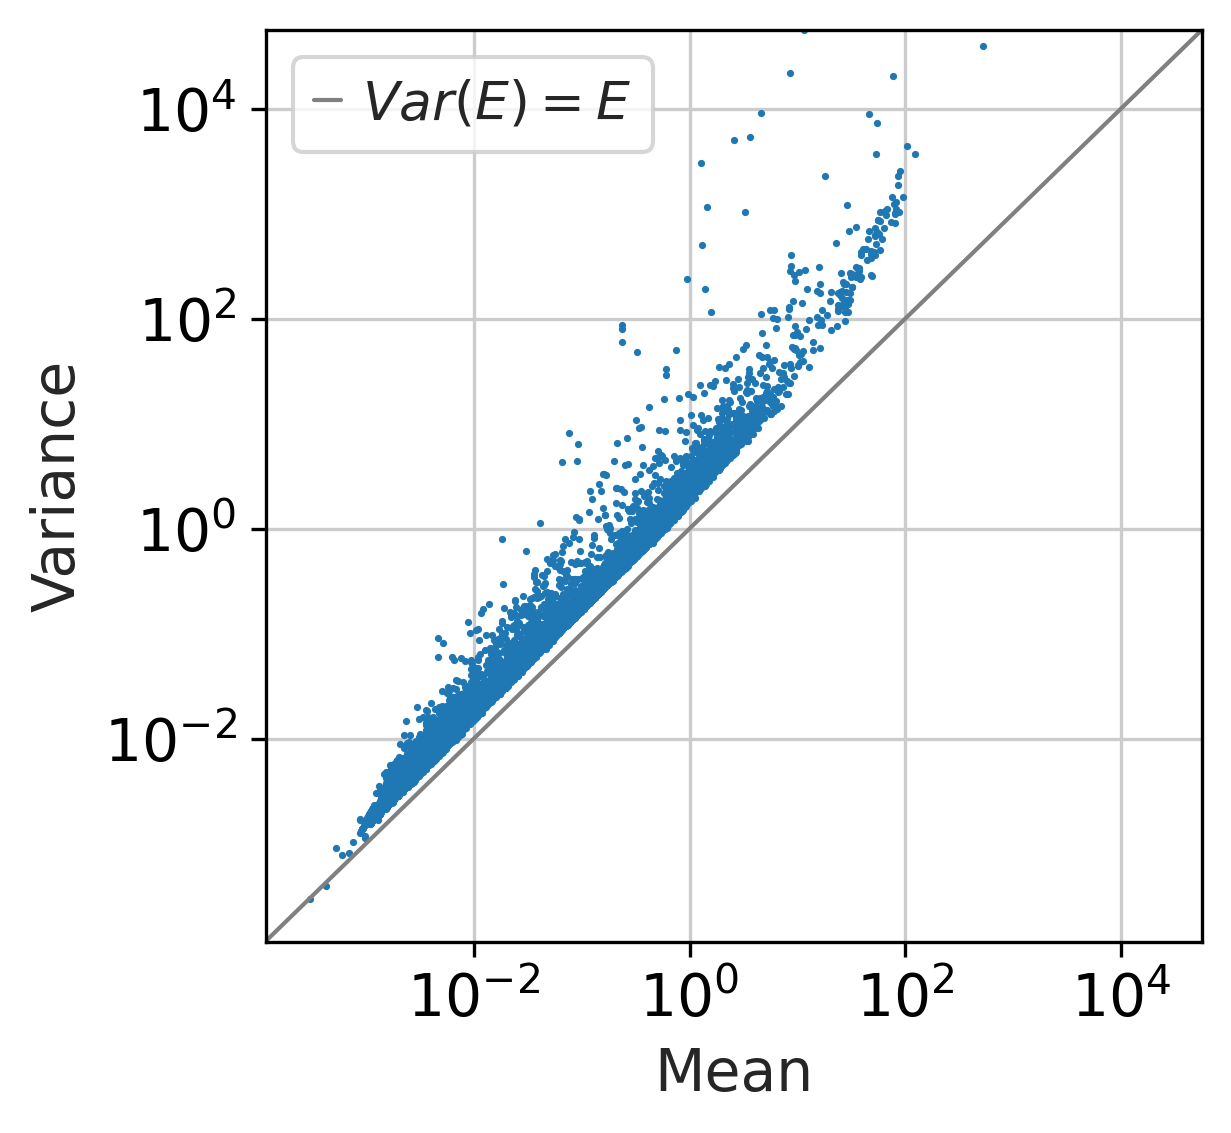

In [ ]:
adata = adata_raw.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
mean_var_plot(adata, log=True)

Картина в целом та же. Это очевидно — CP10k необходим для того, чтобы убрать эффект глубины секвенирования библиотеки, а не овердисперсию. Поэтому чаще всего в связке с нормализацией на глубину библиотеки используют другие функции — логарифмирование или квадратный корень.

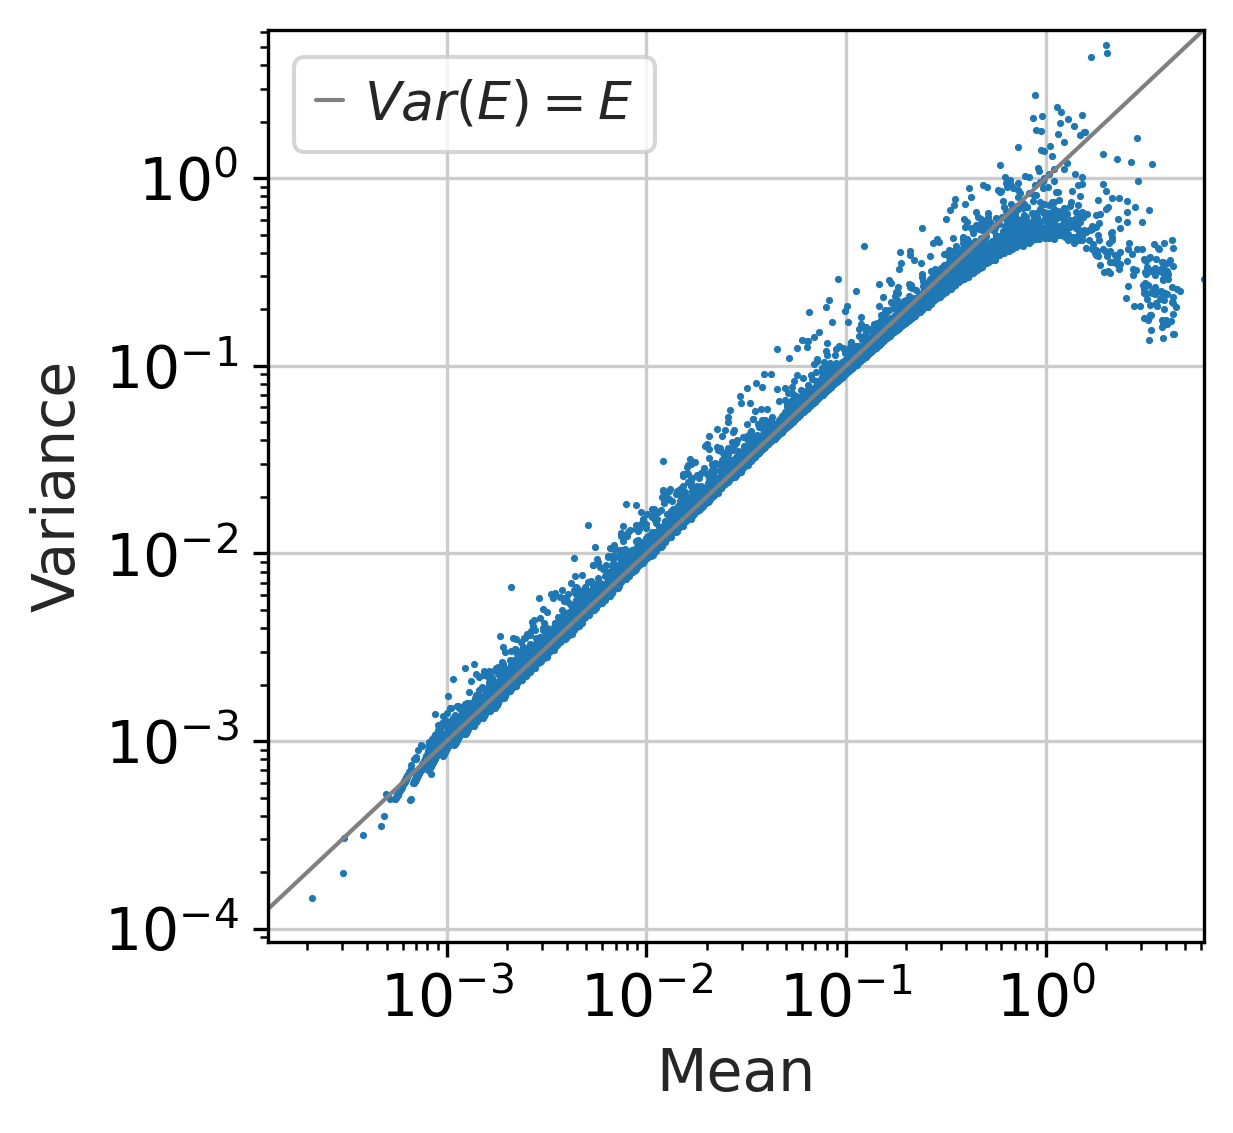

In [ ]:
adata = adata_raw.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
mean_var_plot(adata, log=True)

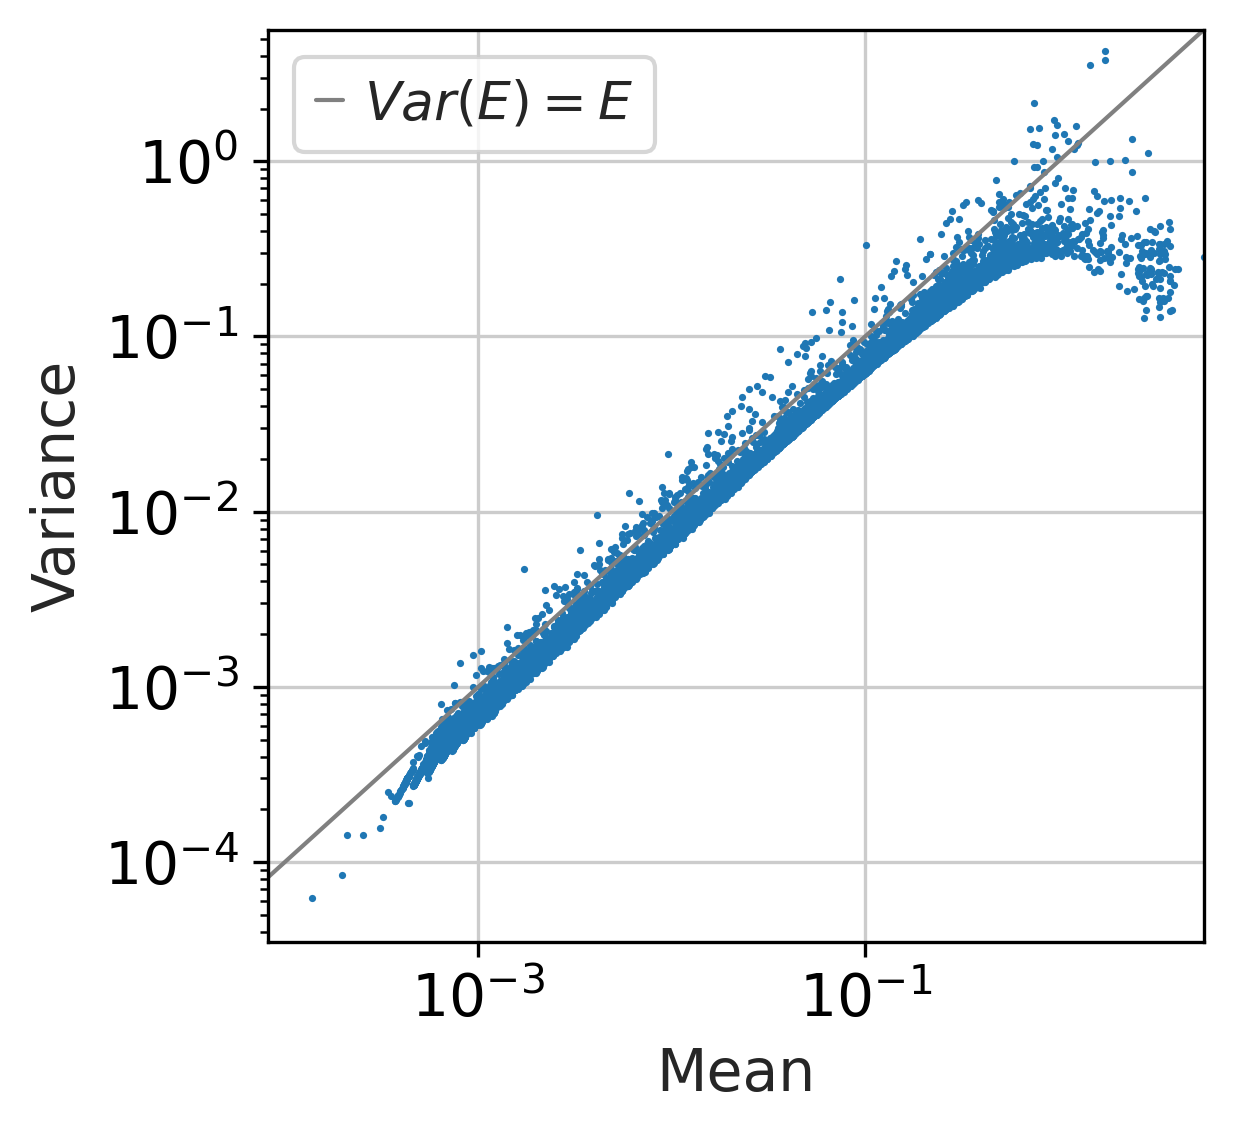

In [ ]:
adata = adata_raw.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
mean_var_plot(adata, log=True)

Уже лучше, но наблюдается странное поведение при высоких значениях экспрессии. Попробуем посмотреть, что будет при взятии логарифма без CP10k:

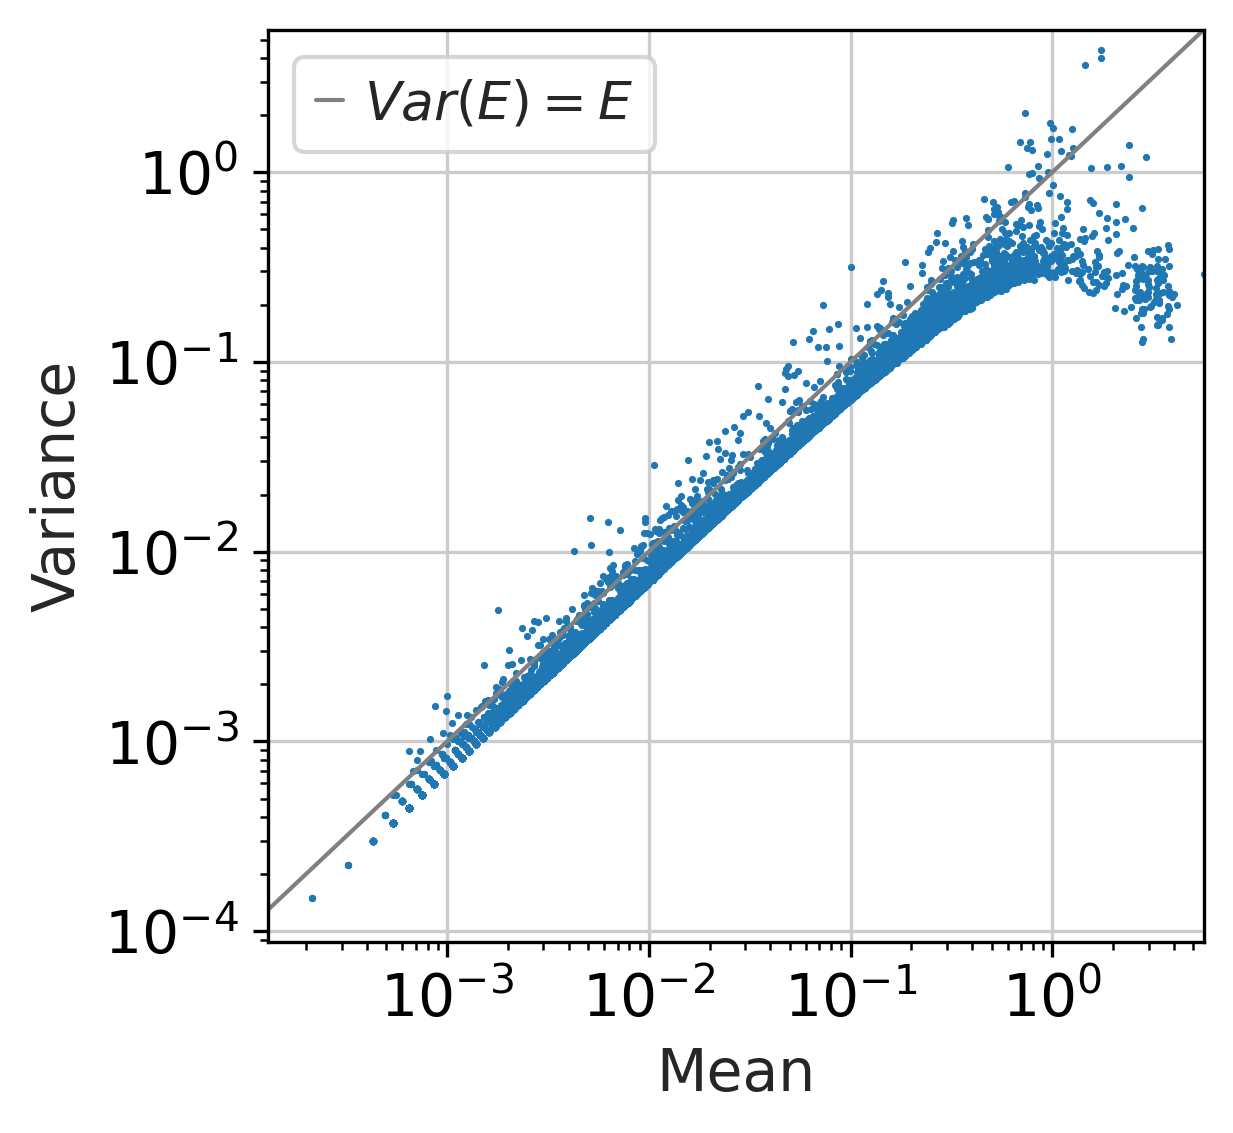

In [ ]:
adata = adata_raw.copy()
sc.pp.log1p(adata)
mean_var_plot(adata, log=True)

Эффект такой же. Аналогичное посмотрим для квадратного корня.

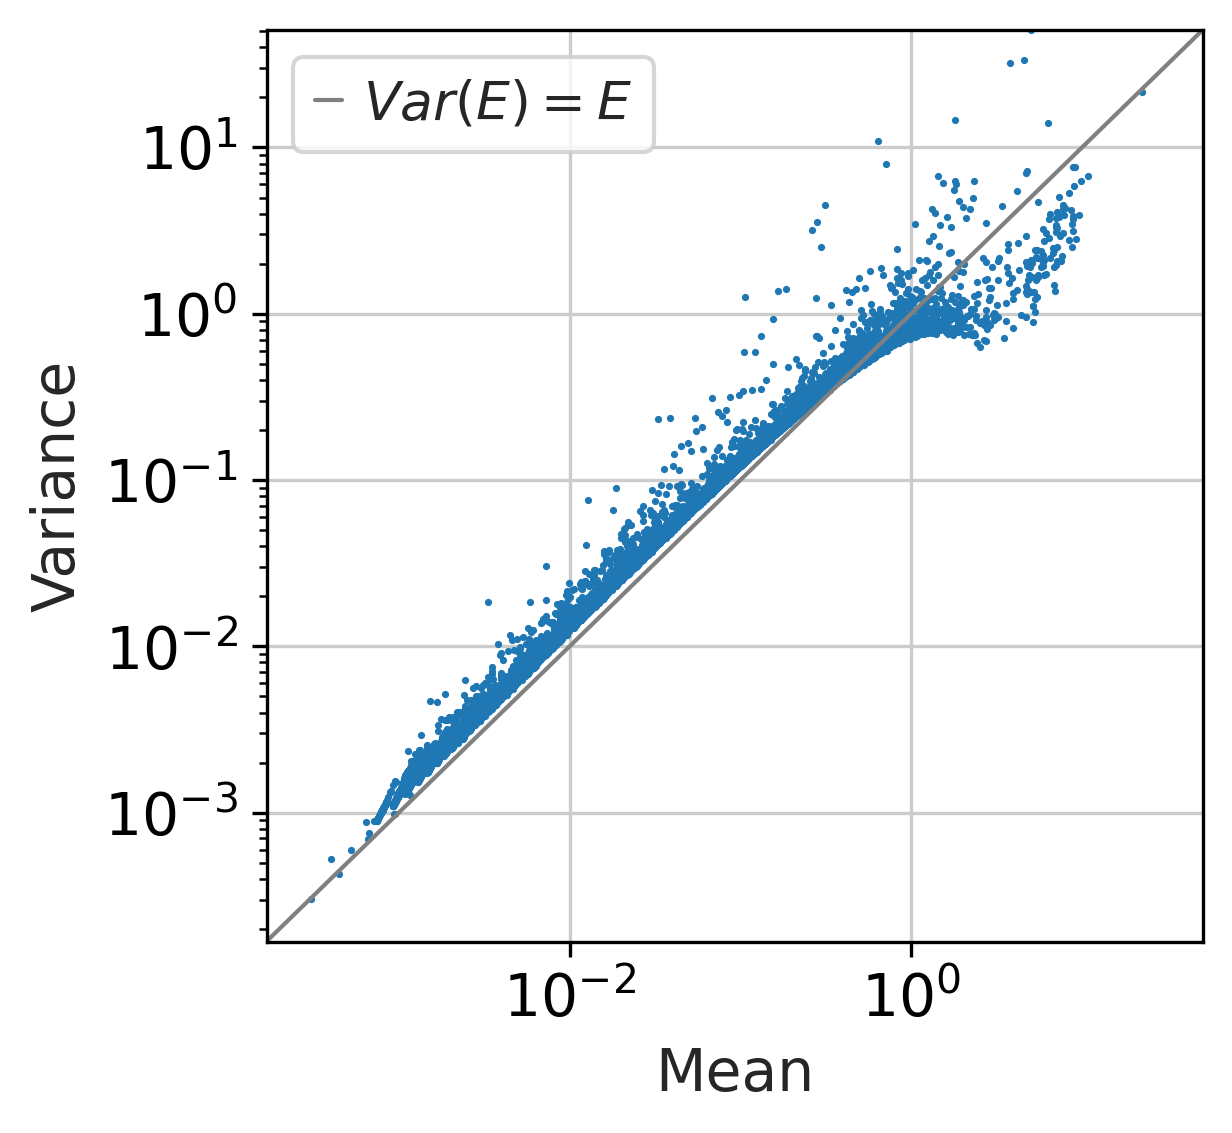

In [ ]:
adata = adata_raw.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.sqrt(adata)
mean_var_plot(adata, log=True)

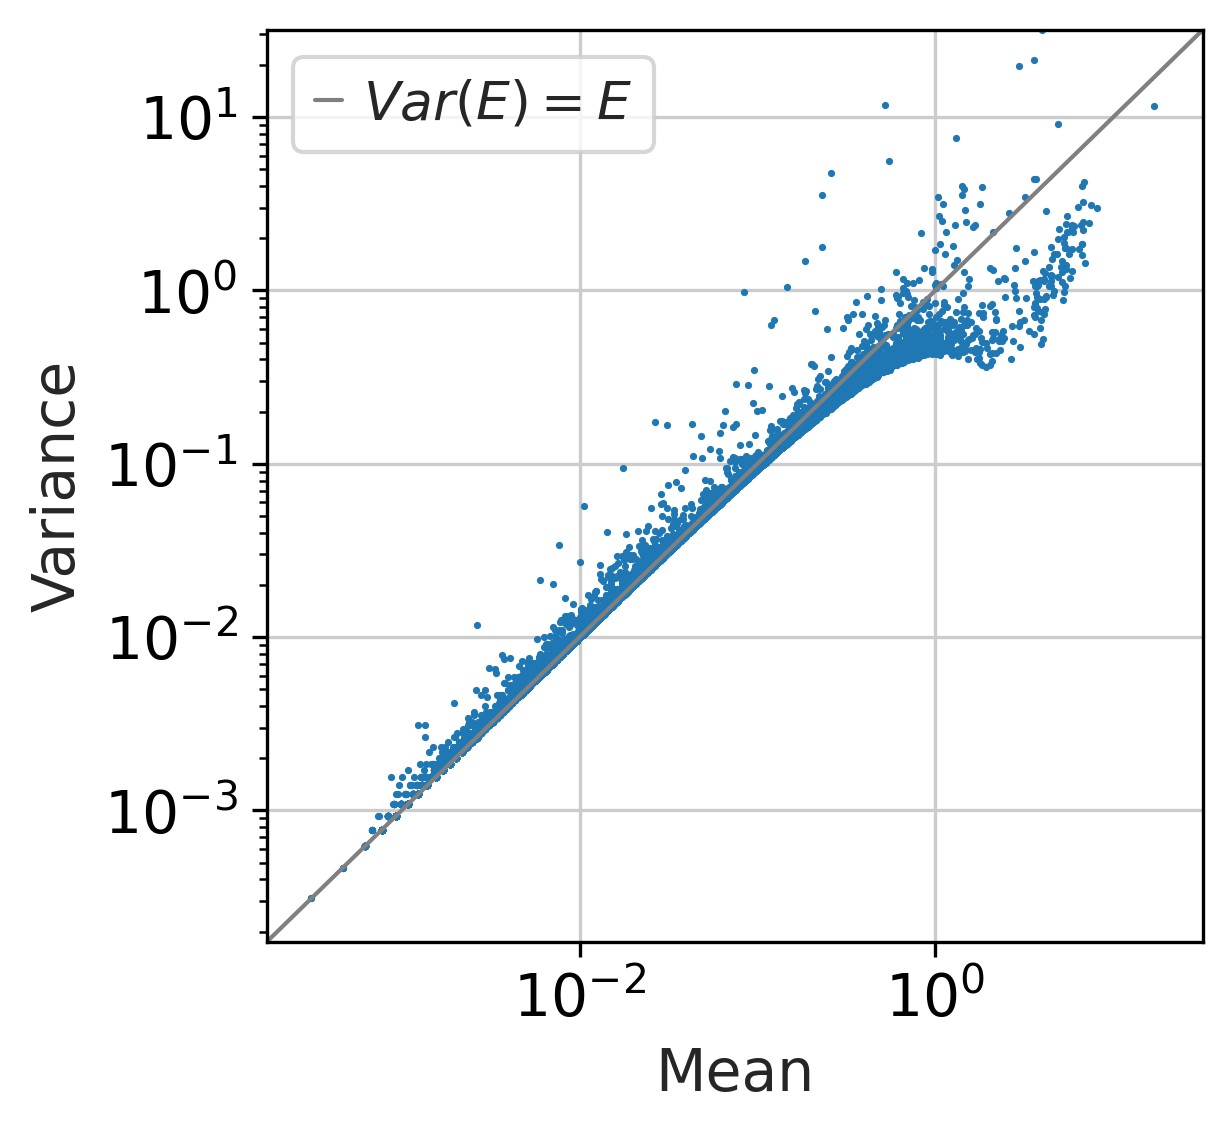

In [ ]:
adata = adata_raw.copy()
sc.pp.sqrt(adata)
mean_var_plot(adata, log=True)

Уже лучше. А что теперь с зависимостью от глубины секвенирования клетки? Есть ли после каждой из трансформаций гены, которые отличаются по экспрессии только из-за того, что мы с разной глубиной отсеквенировали разные клетки?

### Задание

Посмотрите на квадрат коэффециента корреляции $r^2$ для связи между экспрессиями каждого из генов и глубиной секвенирования клетки. Проведите следующие преобразования с данными:
1. PF (линейная норализация типа CPM, только не под определённое число, а под среднее количество каунтов по клеткам),
2. log1pPF — берём логарифм,
3. PFlog1pPF — нормализуем логарифмы линейно под среднюю экспрессию.

Проверьте, насколько сохраняется связь экспрессии гена и глубины секвенирования клетки после этих трансформаций.

In [ ]:
from scipy.stats import pearsonr

adata = adata_raw.copy()
adata.obs["total_UMI"] = adata.X.A.sum(axis=1)
n_UMIs = np.array(adata.obs["total_UMI"])

In [ ]:
adata_PF = sc.pp.normalize_total(adata, copy=True)
adata_log1pPF = sc.pp.log1p(adata_PF, copy=True)
adata_PFlog1pPF = sc.pp.normalize_total(adata_log1pPF, copy=True)

results_r2 = pd.DataFrame({
    "PF" : [pearsonr(
        adata_PF[:, gene].X.A.T[0], n_UMIs
    )[0] ** 2 for gene in adata.var_names],
    "log1pPF" : [pearsonr(
        adata_log1pPF[:, gene].X.A.T[0], n_UMIs
    )[0] ** 2 for gene in adata.var_names],
    "PFlog1pPF" : [pearsonr(
        adata_PFlog1pPF[:, gene].X.A.T[0], n_UMIs
    )[0] ** 2 for gene in adata.var_names]
}, index=adata.var_names)

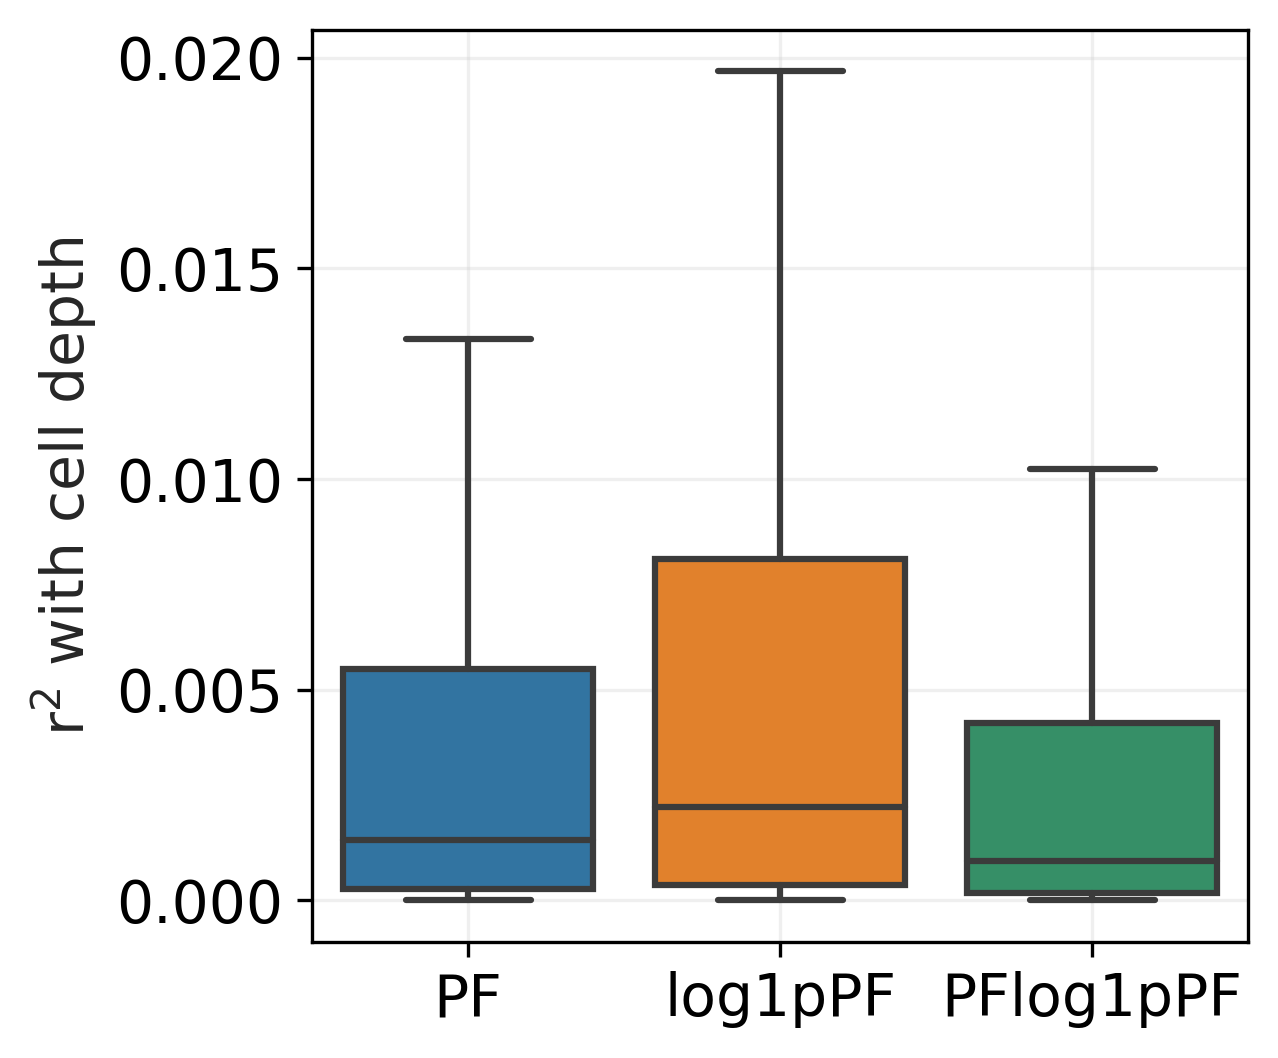

In [57]:
ax = sns.boxplot(data=results_r2, showfliers=False)
ax.set_ylabel("$\mathrm{r}^2$ with cell depth")
ax.grid(alpha=0.3)

### Задание

Реализуйте PFlog1pPF и покажите, как эта трансформация преобразует данные на наших диагностических графиках.

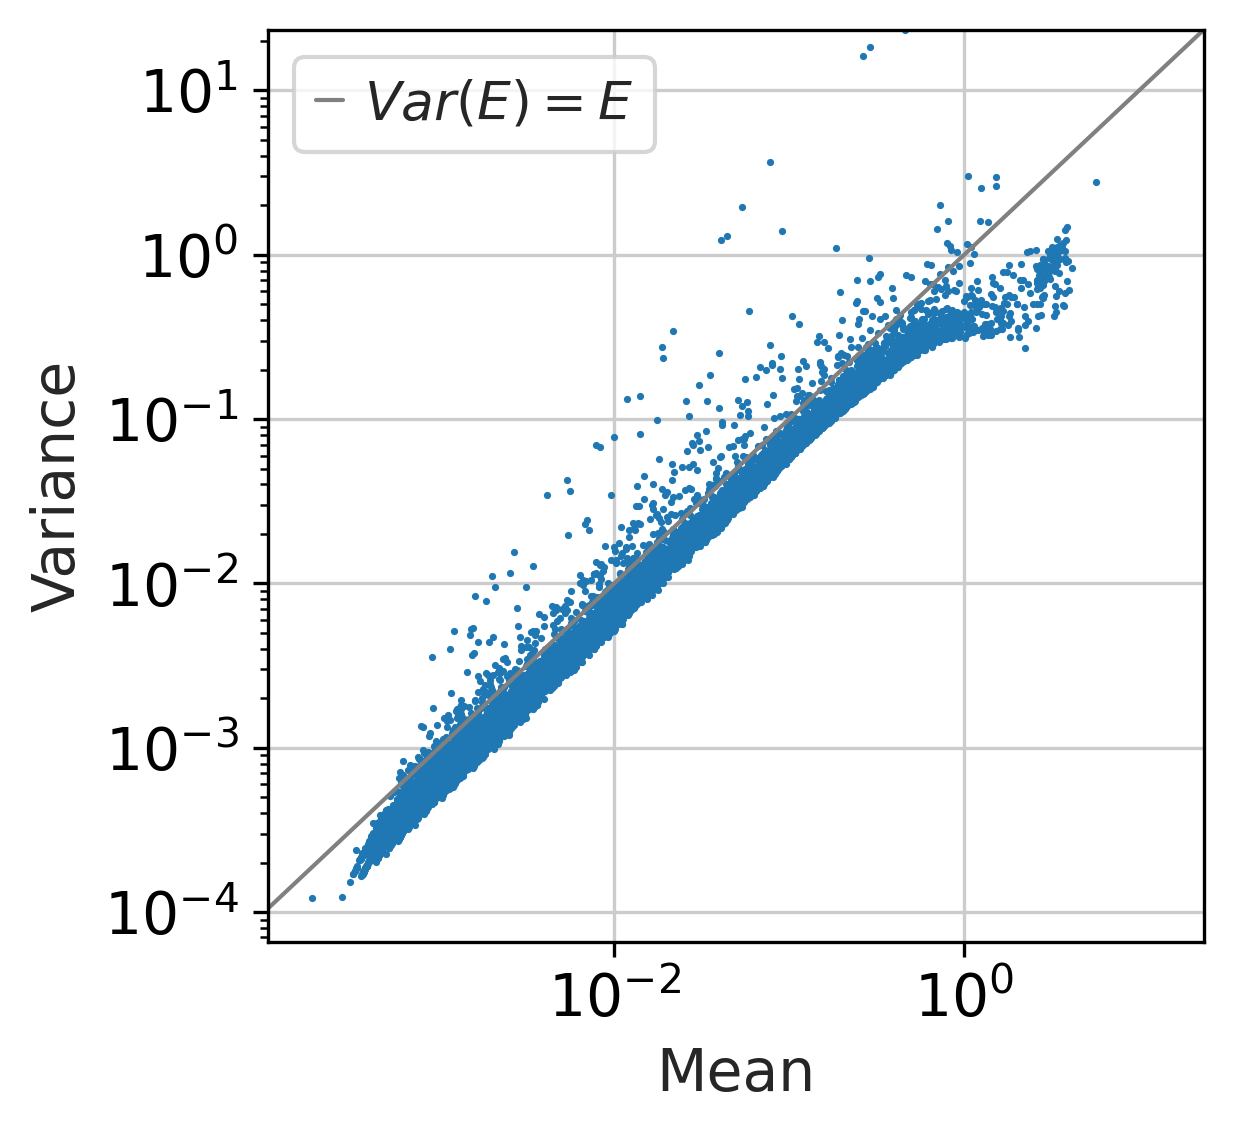

In [ ]:
adata = adata_raw.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.normalize_total(adata)
mean_var_plot(adata, log=True)

## Способы контроля за дисперсией: Pearson residuals

Это преобразование выполняется при помощи функции `sc.experimental.pp.normalize_pearson_residuals`. Подробнее оно рассматривалось на лекции, но, если вы забыли, то <a href="https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02451-7#Sec2">тут</a> можно прочитать статью с описанием метода. Глобально логика в том, что при помощи этого метода мы вычисляем то, насколько экспрессия данного гена отклоняется от того, что мы ожидаем увидеть в каждой из клеток с учётом знаний о доле всех молекул РНК данного типа в образце в целом.

Text(0.5, 0, 'Gene expression mean')

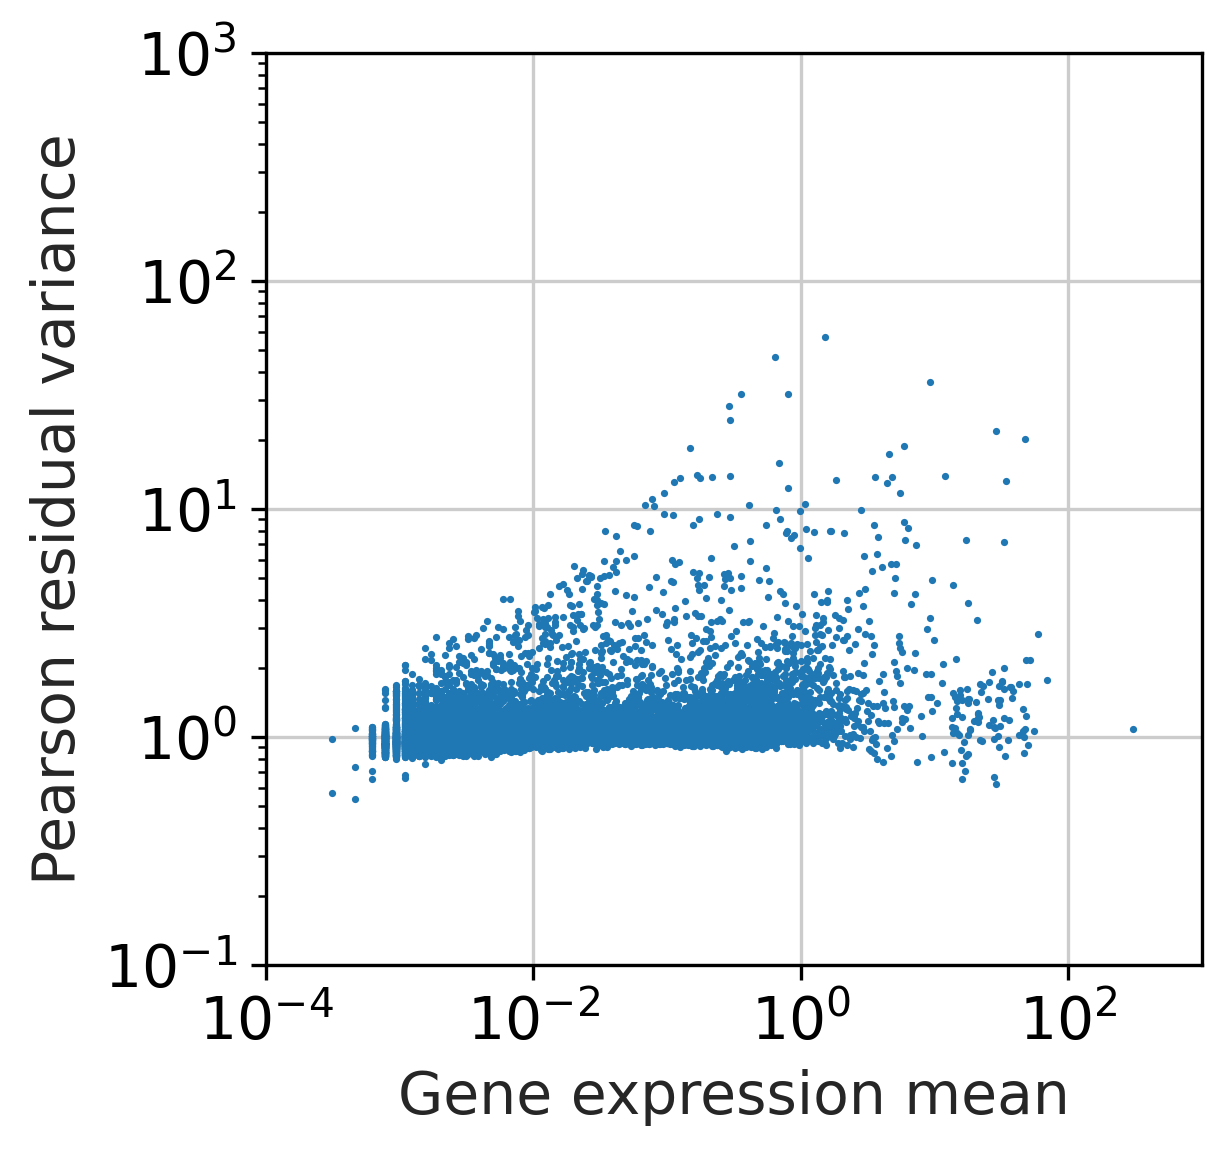

In [ ]:
adata = adata_raw.copy()
sc.experimental.pp.normalize_pearson_residuals(adata, theta = 7.7)

res_var = np.var(adata.X, axis=0)
mean = adata_raw.X.A.mean(axis=0)[res_var > 0]
res_var = res_var[res_var > 0]

ax = sns.scatterplot(x=mean, y=res_var, linewidth=0, s=3)
ax.set_xscale("log"); ax.set_yscale("log")
ax.set_xlim(0.0001, 1000); ax.set_ylim(0.1, 1000)
ax.set_ylabel("Pearson residual variance"); ax.set_xlabel("Gene expression mean")

Именно по этому графику будут выбираться HVG и строиться PCA. Важно: теперь в `adata.X` хранятся остатки регрессии (Pearson residuals), поэтому перепроцессируем датасет так, чтобы его можно было потом использовать для построения UMAP'ов и т.д., т.е. чтобы значения в `adata.X` имели физический смысл экспрессии.

In [ ]:
adata = adata_raw.copy()

In [ ]:
adata.layers["counts"] = adata.X.copy()

In [ ]:
adata = adata_raw.copy()

adata.layers["counts"] = adata.X.copy()
adata.layers["residuals"] = sc.experimental.pp.normalize_pearson_residuals(adata, theta=7.7, copy=True).X

# Дальнейшее будет необходимо для отрисовки, дифференциальной экспрессии и т. п.
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.layers["log1pPF"] = adata.X.copy()

## Использование SCTransform

Запустим SCTransform через anndata2ri и rpy2.

In [ ]:
import rpy2.robjects as ro
ro.globalenv["adata_counts"] = adata_raw
ro.r('SCT.results <- sctransform::vst(assay(adata_counts), vst.flavor="v2")')

Теперь выудим всю необходимую нам информацию из итогового объекта с результатами SCTransform. Обратите внимание, что часть генов были устранены в ходе анализа из-за того, что все их каунты были нулевыми, поэтому также перенесём мета-информацию со списком генов, которые остались в итоговой матрице.

In [ ]:
var_SCT = ro.r("SCT.results$gene_attr")
SCT = ro.r("SCT.results$y")
cells_SCT = ro.r("SCT.results$cells_step1")

adata_SCT = adata_raw.copy()
adata_SCT = adata_SCT[:, var_SCT.index]
adata_SCT.layers["SCTransform"] = SCT.T

Теперь построим диагностический график, который будет отражать зависимость дисперсии остатков NB-регрессии от среднего экспрессии гена.

Text(0.5, 0, 'Gene expression mean')

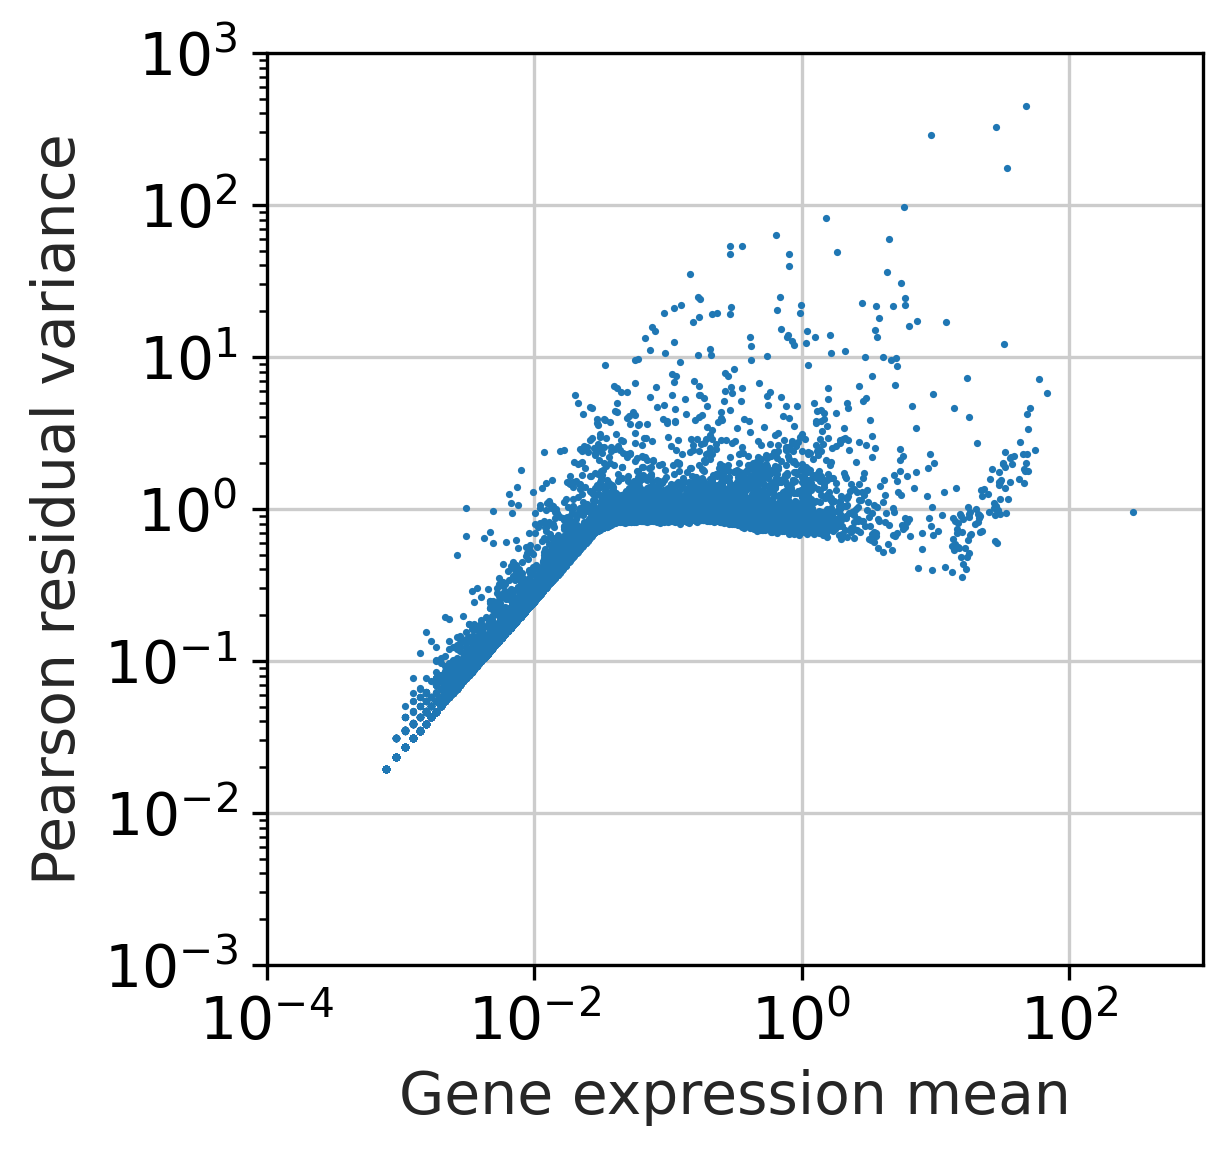

In [ ]:
res_var = np.var(adata_SCT.layers["SCTransform"], axis=0)
mean = adata_SCT.X.A.mean(axis=0)[res_var > 0]
res_var = res_var[res_var > 0]

ax = sns.scatterplot(x=mean, y=res_var, linewidth=0, s=3)
ax.set_xscale("log"); ax.set_yscale("log")
ax.set_xlim(0.0001, 1000); ax.set_ylim(0.001, 1000)
ax.set_ylabel("Pearson residual variance"); ax.set_xlabel("Gene expression mean")

## Домашнее задание

Проверьте поведение проделанных в ходе семинара трансформаций на датасете Smart-seq2. Какие выводы вы можете сделать?

Постройте постройте аналогичный заданию из занятия боксплот с распределением квардарат коэффециента корреляции между экспрессией гена и глубиной секвенирования клетки, только добавьте туда также и корреляцию для остатков регрессии SCTransform (и Analytic Pearson residuals). Есть ли при таких трансформациях зависимость между глубиной секвенирования клетки и экспрессией генов?